# Skin Cancer Classification
HAM10000 ("Human Against Machine with 10000 training images") dataset - a large collection of multi-source dermatoscopic images of pigmented lesions

The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.

It has 7 different classes of skin cancer which are listed below :

* Melanocytic nevi
* Melanoma
* Benign keratosis-like lesions
* Basal cell carcinoma
* Actinic keratoses
* Vascular lesions
* Dermatofibroma

## Importing necessary libraies

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
from PIL import Image
import itertools

# Machine learning specific
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, concatenate, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler

## EDA and Data Preprocessing

Before we can begin training/testing the model, EDA is required to assess what preprocessing will be needed.

In [15]:
meta_data = pd.read_csv("/content/drive/My Drive/CancerImages/HAM10000_metadata.csv")
meta_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [16]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = '/content/drive/My Drive/CancerImages'


imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [17]:
# Add path to image to meta_data
meta_data['path'] = meta_data['image_id'].map(imageid_path_dict.get)
# Add lesion type to image to meta_data
meta_data['cell_type'] = meta_data['dx'].map(lesion_type_dict.get)
# Convert this to categorical
meta_data['cell_type_idx'] = pd.Categorical(meta_data['cell_type']).codes

#Track whihc codes correspond to which cell type
grouped_cell_types = meta_data.groupby('cell_type_idx')['cell_type'].unique()
code_to_name = {key: value[0] for key, value in grouped_cell_types.items()}


# Fill empty ages with mean
meta_data['age'].fillna((meta_data['age'].mean()), inplace=True)

## Setup for ML
Need to to add images to the dataset.

Then need to split into train/validation/test sets.


In [19]:
#Add images to meta_data
meta_data['image'] = meta_data['path'].map(lambda x: np.asarray(Image.open(x)))
df = meta_data.copy(deep=True)

In [20]:
#Set a random state to ensure all splits are consistent
rand_state = 1234
train_test_sz = 0.2
val_sz = 0.1

### Numeric Data

The none image input data can be split into numeric and categorical features. The only numeric feature is the age of the patient.

In [21]:
#Take the age inforation
x_age = np.asarray(df['age'].tolist())

#Split into train/test
x_a_train, x_a_test = train_test_split(
    x_age,
    test_size=train_test_sz,
    random_state=rand_state)


# Scale these based on the mean age
x_a_mean = np.mean(x_a_train)
x_a_train = x_a_train / x_a_mean
x_a_test = x_a_test / x_a_mean

#Split train into validate and train
x_a_train, x_a_validate = train_test_split(
    x_a_train,
    test_size=val_sz,
    random_state=rand_state)

In [22]:
df['age'].mean()

51.863828077927295

### Categorical Data

The rest of the non-image data is categorical. This is the sex of the patient and the localization of the lesion.

In [23]:
# Seperate the categorical data
X_cat = df[['localization', 'sex']]

# Dummy encode this
dummies = pd.get_dummies(
    X_cat,
    prefix = X_cat.columns,
    drop_first=True
    )

# COnvert this to a numpy array
dummies = np.asarray(dummies)

#Perform the test/train and then validation splits
x_train_cat, x_test_cat = train_test_split(
    dummies,
    test_size=train_test_sz,
    random_state=rand_state
    )

x_cat_train, x_cat_validate = train_test_split(
    x_train_cat,
    test_size=val_sz,
    random_state=rand_state
    )

## Rejoin the non-image data

Now recombine the categorical and numeric data so that it can be passed to the neural network.

In [24]:
# Reshape x_a_train to have two dimensions
x_a_train_reshaped = x_a_train.reshape(-1, 1)
x_a_validate_reshaped = x_a_validate.reshape(-1, 1)
x_a_test_reshaped = x_a_test.reshape(-1, 1)

# Concatenate along axis 1
x_num_train = np.concatenate((x_a_train_reshaped, x_cat_train), axis=1)
x_num_val = np.concatenate((x_a_validate_reshaped, x_cat_validate), axis=1)
x_num_test = np.concatenate((x_a_test_reshaped, x_test_cat), axis=1)

### Image Data

Now, test/train split and preprocess the image data

In [25]:
# Select features of target
features = df['image']
target = df['cell_type_idx']

# Split into test/train sets
x_train_o, x_test_o, y_train, y_test = train_test_split(
    features,
    target,
    test_size=train_test_sz,
    random_state=rand_state
    )

# Select just images as x_train/x_test
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

# Split training into training and validation
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train,
    y_train,
    test_size=val_sz,
    random_state=rand_state
    )


# Reshape image in 3 dimensions (height = 75px, width = 100px, channels = 3)
x_train_img = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test_img = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate_img = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

## Model Setup

Now the data has been appropriately preprocessed, the model must be set up so it can be trained on the data.

In [32]:
# Define the two sets of inputs
inputA = Input(shape=(x_num_train.shape[1],))
inputB = Input(shape=(75, 100, 3))

# the first branch operates on the first input
x = Dense(8, activation="relu")(inputA)
x = Dense(4, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)

# the second branch opreates on the second input
y = Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same')(inputB)
y = Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same')(y)
y = MaxPool2D(pool_size = (2,2))(y)
y = Dropout(0.25)(y)
y = Conv2D(64, kernel_size = (3,3), activation = 'relu')(y)
y = Conv2D(64, kernel_size = (3,3), activation = 'relu')(y)
y = MaxPool2D(pool_size = (2,2))(y)
y = Dropout(0.4)(y)
y = Flatten()(y)
y = Model(inputs=inputB, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(128, activation="relu")(combined)
z = Dense(7, activation="softmax")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

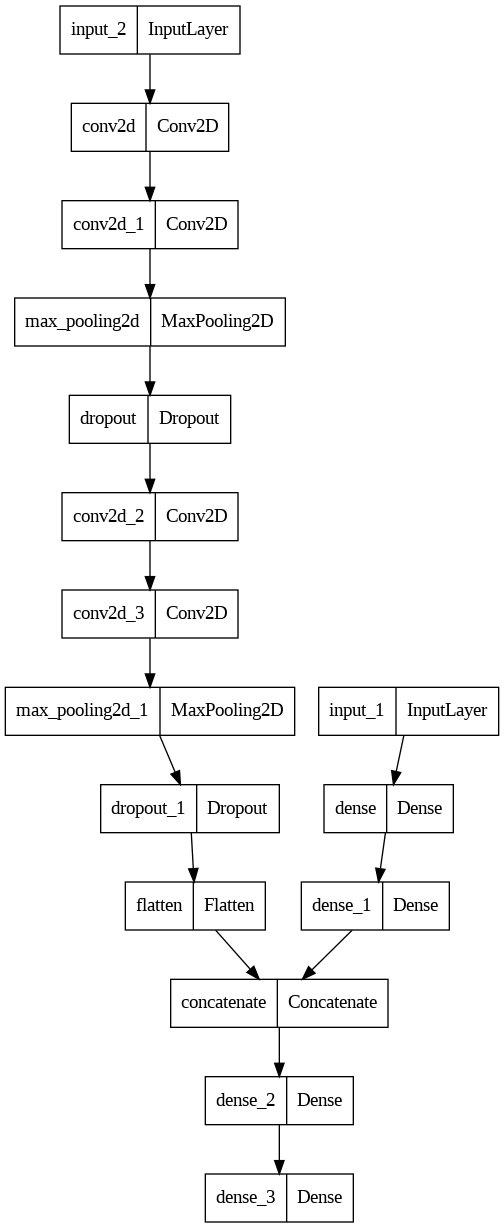

In [27]:
plot_model(
    model,
    to_file='/content/drive/My Drive/CancerImages/Models/multi_input_model_plot.png'
    )

Epoch 1/3
226/226 [==============================] - 276s 1s/step - loss: 0.5230 - sparse_categorical_accuracy: 0.8069 - val_loss: 0.6913 - val_sparse_categorical_accuracy: 0.7481
Epoch 2/3
226/226 [==============================] - 274s 1s/step - loss: 0.4620 - sparse_categorical_accuracy: 0.8331 - val_loss: 0.7039 - val_sparse_categorical_accuracy: 0.7706
Epoch 3/3
226/226 [==============================] - 280s 1s/step - loss: 0.4177 - sparse_categorical_accuracy: 0.8452 - val_loss: 0.7415 - val_sparse_categorical_accuracy: 0.7556


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


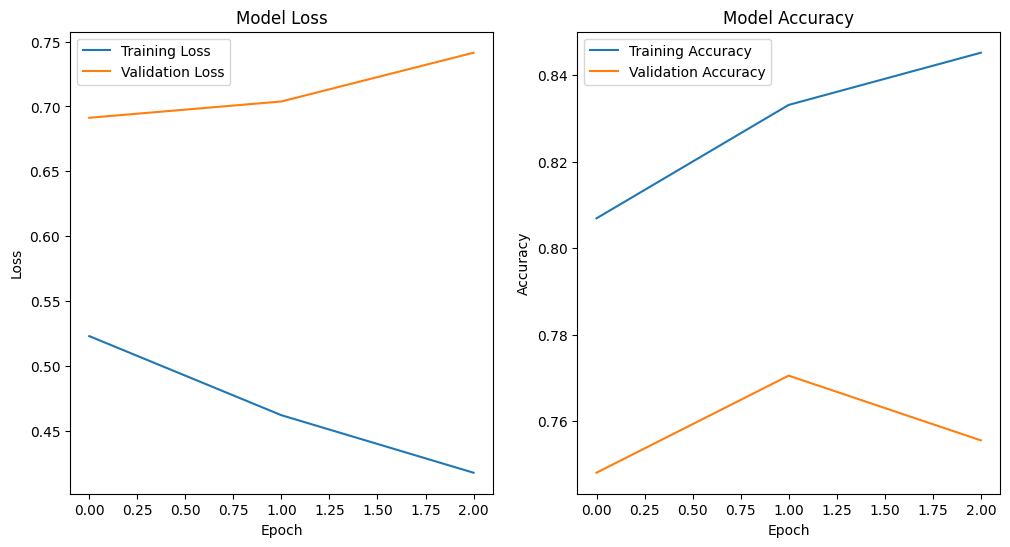

In [34]:
# model = load_model("/content/drive/My Drive/CancerImages/Models/multi_input_model.h5")

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
    )

model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
    )

# Train the model and get the history
history = model.fit(
    x = [x_num_train, x_train_img],
    y=y_train, epochs=3,
    validation_data=([x_num_val, x_validate_img], y_validate),
    callbacks=[early_stopping]
    )


model.save("/content/drive/My Drive/CancerImages/Models/multi_input_model.h5")

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Model Performance

63/63 [==============================] - 19s 296ms/step


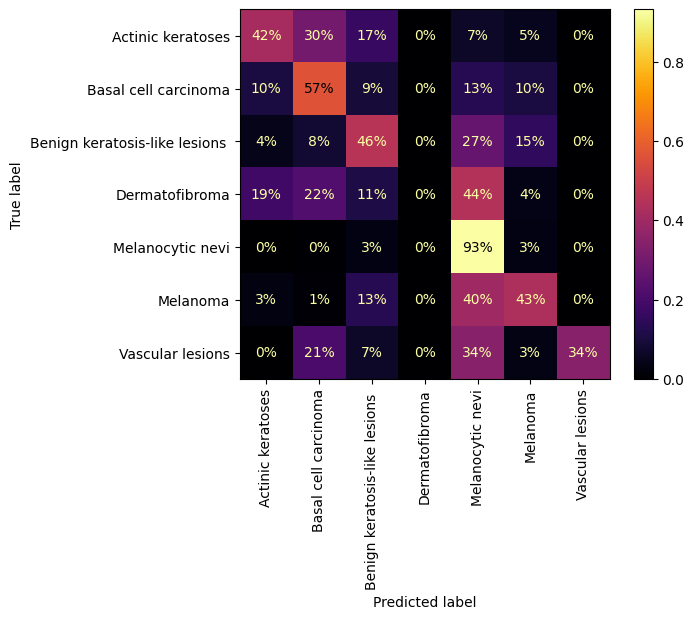

In [36]:
# Predict the values from the validation dataset
Y_pred = model.predict([x_num_test, x_test_img])

# # # Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)


# Display the confusion matrix with rotated x-axis labels
ConfusionMatrixDisplay.from_predictions(y_test, Y_pred_classes,display_labels=list(code_to_name.values()), cmap='inferno', normalize='true', values_format=".0%")
plt.xticks(rotation=90)
plt.grid(False)
plt.show()